# Multinomial Naive Bayes Modeling

## Pull & Clean Datasets

In [ ]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df_train = pd.read_csv('hate_speech_training.csv')
df_train_2 = pd.read_csv('hate_speech_training_2.csv')
df_train_3 = pd.read_csv('hate_speech_training_3.csv')
df_train_4 = pd.read_csv('hate_speech_training_4.tsv', sep = '\t')
df_train_5 = pd.read_csv('hate_speech_training_5.csv')

In [ ]:
df_train = df_train.drop('id', axis = 1) #0 = Not Hate Speech, 1 = Hate Speech

In [ ]:
df_train_2 = df_train_2[['tweet', 'class']]
df_train_2['class'] = df_train_2['class'].replace([0], 'hate speech')
df_train_2['class'] = df_train_2['class'].replace([1, 2], 'not hate speech')
df_train_2['class'] = df_train_2['class'].replace(['hate speech'], 1)
df_train_2['class'] = df_train_2['class'].replace(['not hate speech'], 0)
df_train_2.rename(columns = {'class': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [ ]:
df_train_3 = df_train_3.drop('index', axis = 1) 
df_train_3.rename(columns = {'post': 'tweet'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [ ]:
df_train_4 = df_train_4[['text', 'HS']] 
df_train_4.rename(columns = {'text': 'tweet', 'HS': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [ ]:
df_train_5['Label'] = df_train_5['Label'].replace(['Hate', 'Non-Asian Aggression'], 1)
df_train_5['Label'] = df_train_5['Label'].replace(['Neutral', 'Counterhate'], 0) 
df_train_5.rename(columns = {'Text': 'tweet', 'Label': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [ ]:
dfs = [df_train, df_train_2, df_train_3, df_train_4, df_train_5]
df = pd.concat(dfs)

## Train, Test, Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df['tweet']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=3,
                                                    test_size=0.20,
                                                   stratify = y) #80/20 split

## Pipeline for TF-IDF on Multinomial Bayes

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
tfidf_mb_pipe = Pipeline([
 ('tfidf', TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words = 'english')),
 ('SMOTE', SMOTE(n_jobs = -1)),
 ('mnb', MultinomialNB())
])

In [ ]:
tfidf_mb_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern="([a-zA-Z]+(?:'[a-z]+)?)",
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('SMOTE',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=-1,
                 

In [ ]:
tfidf_mnb_params = {
    'tfidf__max_features':[None, 25_000, 10_000, 1_000, 100],
    'tfidf__ngram_range':[(1,1), (1,2), (2,2)],
    'tfidf__binary':[False, True],
    'tfidf__norm': ['l1', 'l2']
}

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
gs_tfidf_mnb = GridSearchCV(tfidf_mb_pipe,
                            param_grid=tfidf_mnb_params, 
                            cv = 3, 
                            verbose = 1,
                            n_jobs = -1)

In [ ]:
gs_tfidf_mnb.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 23.7min


In [26]:
gs_tfidf_mnb.best_score_

0.8959851286142783

In [27]:
gs_tfidf_mnb.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=True,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l1',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern="([a-zA-Z]+(?:'[a-z]+)?)",
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('SMOTE',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=-1,
                  

In [28]:
gs_tfidf_mnb.best_params_

{'tfidf__binary': True,
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l1'}

## Best Possible Multinomial Bayes Model with TF-IDF

In [39]:
tfidf_mb_best_pipeline = Pipeline([
                                   ('tfidf', TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)", 
                                                             stop_words = 'english', max_features = None,
                                                             ngram_range = (1,2), binary = True, norm = 'l1')),
                                   ('SMOTE', SMOTE(n_jobs = -1)),
                                   ('mnb', MultinomialNB())
                                   ])

In [40]:
tfidf_mb_best_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=True,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l1',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern="([a-zA-Z]+(?:'[a-z]+)?)",
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('SMOTE',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=-1,
                  

In [41]:
tfidf_mb_best_pipeline.score(X_train, y_train)

0.9587848962385338

In [42]:
from sklearn.model_selection import cross_val_score

In [43]:
cross_val_score(tfidf_mb_best_pipeline, X_train, y_train, cv = 8)

array([0.89926183, 0.90505138, 0.90418295, 0.90345926, 0.8983934 ,
       0.90230135, 0.89491967, 0.89866821])

In [44]:
tfidf_mb_best_pipeline.score(X_test, y_test)

0.9097553915183094

In [35]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

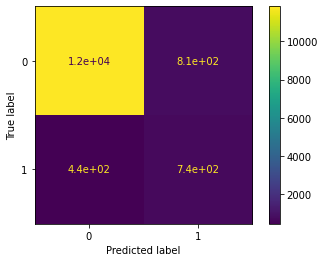

In [45]:
plot_confusion_matrix(tfidf_mb_best_pipeline, X_test, y_test)

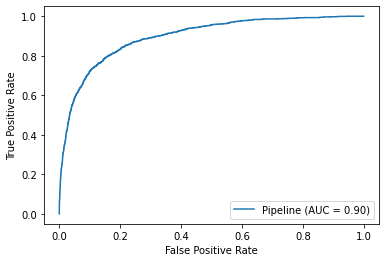

In [46]:
plot_roc_curve(tfidf_mb_best_pipeline, X_test, y_test)

In [47]:
y_hat = tfidf_mb_best_pipeline.predict(X_test)
print(classification_report(y_pred = y_hat, y_true = y_test))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     12643
           1       0.48      0.63      0.54      1175

    accuracy                           0.91     13818
   macro avg       0.72      0.78      0.75     13818
weighted avg       0.92      0.91      0.92     13818



## Pipeline for Count Vectorizer on Multinomial Bayes

In [48]:
cv_mb_pipeline = Pipeline([
 ('cv', CountVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words = 'english')),
 ('SMOTE', SMOTE(n_jobs = -1)),
 ('mnb', MultinomialNB())
])

In [49]:
cv_mb_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cv',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern="([a-zA-Z]+(?:'[a-z]+)?)",
                                 tokenizer=None, vocabulary=None)),
                ('SMOTE',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=-1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('mnb',
   

In [50]:
cv_mnb_params = {
    'cv__max_features':[None, 25_000, 10_000, 1_000, 100],
    'cv__ngram_range':[(1,1), (1,2), (2,2)],
    'cv__binary':[False, True],
    }

In [51]:
gs_cv_mnb = GridSearchCV(cv_mb_pipeline,
                            param_grid=cv_mnb_params, 
                            cv = 3, 
                            verbose = 1,
                         n_jobs = -1)

In [52]:
gs_cv_mnb.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 25.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cv',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prepro

In [71]:
gs_cv_mnb.best_score_

0.9269237123258058

In [72]:
gs_cv_mnb.best_estimator_

Pipeline(memory=None,
         steps=[('cv',
                 CountVectorizer(analyzer='word', binary=True,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern="([a-zA-Z]+(?:'[a-z]+)?)",
                                 tokenizer=None, vocabulary=None)),
                ('SMOTE',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=-1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('mnb',
    

In [73]:
gs_cv_mnb.best_params_

{'cv__binary': True, 'cv__max_features': None, 'cv__ngram_range': (1, 2)}

## Best Possible Multinomial Bayes Model with Count Vectorizer

In [59]:
cv_best_mb_pipeline = Pipeline([
                                ('cv', CountVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words = 'english',
                                                       max_features = None, ngram_range = (1,2), binary = True)),
                                ('SMOTE', SMOTE(n_jobs = -1)),
                                ('mnb', MultinomialNB())
])

In [60]:
cv_best_mb_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cv',
                 CountVectorizer(analyzer='word', binary=True,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern="([a-zA-Z]+(?:'[a-z]+)?)",
                                 tokenizer=None, vocabulary=None)),
                ('SMOTE',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=-1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('mnb',
    

In [67]:
cv_best_mb_pipeline.score(X_train, y_train)

0.9768775668976497

In [68]:
cross_val_score(cv_best_mb_pipeline, X_train, y_train, cv = 8)

array([0.92213055, 0.92835432, 0.92893328, 0.9286438 , 0.92907801,
       0.93081488, 0.92560428, 0.92834395])

In [69]:
cv_best_mb_pipeline.score(X_test, y_test)

0.9247358517875235

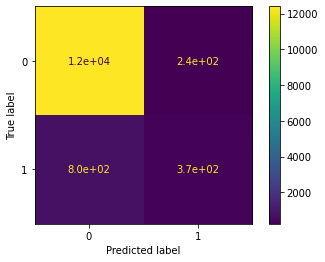

In [70]:
plot_confusion_matrix(cv_best_mb_pipeline, X_test, y_test)

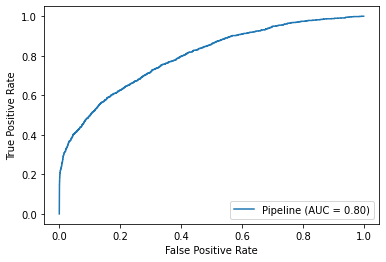

In [74]:
plot_roc_curve(cv_best_mb_pipeline, X_test, y_test);

In [75]:
y_hat_2 = cv_best_mb_pipeline.predict(X_test)
print(classification_report(y_pred = y_hat_2, y_true = y_test))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     12643
           1       0.61      0.31      0.42      1175

    accuracy                           0.92     13818
   macro avg       0.78      0.65      0.69     13818
weighted avg       0.91      0.92      0.91     13818

